<a href="https://colab.research.google.com/github/Aparajita289/Writers-and-authors/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [ ]:
!gdown --id 1t4o0D2PmJr-zp0wGd-48lL7M5XqVKIr2

In [ ]:
!unzip /content/MALARIA.zip

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
import torch.nn as nn

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch = 64

dataset = torchvision.datasets.ImageFolder(root='/content/cell_images', transform=transform)
#print(len(dataset))
trainset, testset = torch.utils.data.random_split(dataset, [20000, 7558])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=True, num_workers=2)
classes = ('parasitized', 'uninfected')
#print(len(trainset))
#print(len(testset))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

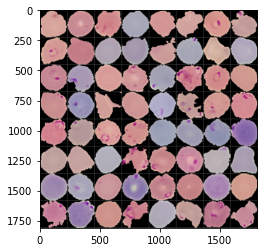

parasitized uninfected uninfected parasitized uninfected uninfected parasitized parasitized parasitized uninfected uninfected uninfected uninfected parasitized uninfected uninfected parasitized parasitized uninfected parasitized parasitized parasitized parasitized uninfected parasitized parasitized uninfected uninfected parasitized parasitized parasitized parasitized parasitized parasitized parasitized parasitized parasitized parasitized parasitized parasitized uninfected uninfected uninfected parasitized parasitized parasitized parasitized uninfected uninfected parasitized uninfected parasitized parasitized uninfected uninfected uninfected parasitized parasitized uninfected parasitized uninfected parasitized parasitized parasitized


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch)))

Transfer Learning

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
model

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=2)
model

In [ ]:
model(images)

**TRAINING**

In [ ]:
#check if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
step = 0
loss_train = []
loss_val = []

#import the model
net = torchvision.models.resnet18()
net = net.to(device)
net = net.train()

min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
file = open('logs_test4_epoch100_with_max_pool.txt', 'w')

print('training started.............................................')
file.write('training started.............................................\n')
start_time = time.time()
for epoch in range(3):  # loop over the dataset multiple times
    #file.write('##############################TRAINING###############################\n')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %(epoch + 1, i + 1, running_loss / 2000))
            #log_loss_summary(logger, loss_train, step, prefix = 'train_')
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'train_loss = '+'\t'+str(np.mean(loss_train)) +'\n')
            loss_train = []
            running_loss = 0.0
            
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    file.write('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time) + '\n')
    file.write('##################################evaluation##############################\n')
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            #torch.save(net.state_dict(), 'weight/' + 'epoch_' + str(epoch+1) + 'loss_' + str(val_loss) + '.pt')
            print(str(val_loss))
            torch.save(net.state_dict(), 'xyz_epoch_'+str(epoch+1)+'.pt')
            
            print('performance improved with validation loss ' + str(val_loss))
            file.write('--------------------------------------------------------------------\n')
            file.write('performance improved with validation loss =  ' + str(val_loss) + '\n')
            
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'val_loss = '+'\t'+str(np.mean(loss_val)) +'\n')
            file.write('--------------------------------------------------------------------\n\n')
            #log_loss_summary(logger, loss_val, step, prefix="val_")
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            file.write('no improvement with prev best model ' + str(no_impr_epoch) + 'th \n')
            
        if no_impr_epoch > patience:
            print('stop training')
            file.write('stop training')
            break
    
print('Finished Training................................................')
file.write('Finished Training................................................\n')
end_time = time.time()
file.write('Training time:- ' + str(end_time - start_time))
file.close()

In [ ]:

PATH = 'xyz_epoch_3.pt'
model = torchvision.models.resnet18()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

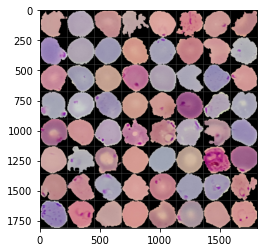

Ground Truth:  uninfected uninfected uninfected uninfected parasitized parasitized parasitized uninfected parasitized uninfected uninfected uninfected parasitized uninfected uninfected parasitized uninfected uninfected uninfected parasitized uninfected uninfected parasitized parasitized parasitized parasitized parasitized uninfected parasitized parasitized parasitized uninfected parasitized uninfected parasitized parasitized parasitized parasitized parasitized uninfected uninfected parasitized parasitized uninfected uninfected uninfected parasitized parasitized parasitized parasitized parasitized uninfected parasitized parasitized parasitized parasitized parasitized parasitized uninfected uninfected parasitized parasitized uninfected parasitized


In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch)))

Predicted:  uninfected uninfected uninfected uninfected parasitized parasitized parasitized uninfected parasitized uninfected uninfected uninfected parasitized uninfected uninfected parasitized uninfected uninfected uninfected parasitized uninfected uninfected parasitized parasitized parasitized parasitized parasitized uninfected parasitized parasitized parasitized uninfected parasitized uninfected parasitized parasitized parasitized parasitized parasitized uninfected uninfected parasitized parasitized uninfected uninfected uninfected parasitized parasitized parasitized parasitized parasitized uninfected parasitized parasitized parasitized parasitized parasitized parasitized uninfected uninfected uninfected parasitized uninfected parasitized


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 27758 test images: %d %%' % (100 * correct / total))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdba0ff3560>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdba0ff3560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Accuracy of the network on the 3776 test images: 95 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of parasitized : 90 %
Accuracy of uninfected : 93 %
